In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
import random
import csv
import math
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

**Lab exercise: neural language modeling**  
 (Adapted from C. Corro's)  
 The goal of this lab exercise is build two neural language models: a neural n-gram model based on a simple MLP an autoregressive model based on a LSTM Although the n-gram model is straighforward to code, there are a few "tricks" that you need to implement for the autoregressive model:
 - word dropout
 - variational dropout
 - loss function masking

 **Variational dropout**  
 The idea of variational dropout is to apply the same mask at each position for a given sentence (if there are several sentences in a minibatch,
 use different masks for each input). The idea is as follows:
 - assume a sentence of n words whose embeddings are e_1, e_2, ...e_n
 - at the input of the LSTM, instead of applying dropout independently to each embedding, sample a single mask that will be applied
 similarly at each position
 - same at the output of the LSTM
 See Figure 1 of this paper: 
https://proceedings.neurips.cc/paper/2016/ le/076a0c97d09cf1a0ec3e19c7f2529f2b-Paper.pdf
 To implement this, you need to build a custom module that applies the dropout only if the network is in training mode.

 **Data processing**  
 Download the data here:   
https://github.com/google-research/google-research/tree/master/goemotions/data
 You need to use train.tsv, dev.tsv, test.tsv
 - build a word dictionnary (mapping between words and integers). You will need to add a special token "BOS" to the dictionnary even if it
 doesn't appear in sentences (If you want to generate data, you will also need a "EOS" token).
 - build python list of integers representing each input. For example, for the sentence "I sleep", the tensor could look like [10, 5] if 10 is the
 integer associated with "I" and 5 the integer associated with "sleep". You can add this directly to the dictionnaries in *_data

**Evaluation**  
For evaluation, you must compute the perplexity of the test dataset (i.e. assume the dataset is one very long sentence), see:
https://lena-voita.github.io/nlp_course/language_modeling.html#evaluation  
Note that you don't need to explicitly compute the root, you can use log probabilities and properties of log functions for this. As duringevaluation, you will see sentences one after the other, you can code a small class to keep track of log probabilities of words and compute theglobal perplexity at the end.

In [5]:
class Perplexity:
    def __init__(self):
        self.reset()

    def reset(self):
        self.total_log_prob = 0.0 
        self.total_words = 0       

    def add_sentence(self, log_probs):
        # log_probs: vector of log probabilities of words in a sentence
        self.total_log_prob += sum(log_probs)
        self.total_words += len(log_probs)

    def compute_perplexity(self):
        if self.total_words == 0:
            return float('inf')

        avg_neg_log_prob = - self.total_log_prob / self.total_words
        return math.exp(avg_neg_log_prob)


**Neural n-gram model**  
The model must be similar to the one presented in the course notes. Todo:  
- transform the data into tensors --- note that you can decompose your data to have input tensors of shape 2 and a unique output, why? Youwill need to pad the sentence with <BOS> tokens --- why do you need two before the fi rst word?
- train the network
- compute perplexity of the test data

**LSTM model**  
This model should rely on a LSTM.  
- transform the data into tensors => you can't use the same trick as for the n-gram model
- train the network by batching the input --- be very careful when computing the loss function! And explain how to batch data, compute theloss with batch data, etc, in the report!
- compute the perplexity on the test data
- implement variational dropout at input and output of the LSTM  
  
Warning: you need to use the option batch_fi rst=True for the LSTM.

**Comparison of the two models**  
In the report, compare the two models.
Discuss the structure and shape of the data, hyperparameters you tuned.
Discuss how long the different steps of process take.

# Neural N-gram model

In [6]:
############################################
# PREPROCESSING
############################################

def load_tsv(path):
    data = []
    with open(path, "r", encoding="utf-8") as f:
        reader = csv.reader(f, delimiter="\t")
        
        for row in reader:
            text = row[0].strip()
            text = text.lower()
            words = text.split() 
            data.append({"text": words})
    return data

train_data = load_tsv("train.tsv")
dev_data   = load_tsv("dev.tsv")
test_data  = load_tsv("test.tsv")

print("Train examples:", len(train_data))
print("Dev examples:", len(dev_data))
print("Test examples:", len(test_data))
print(train_data[0])


class WordDict:
    # constructor, words must be a set containing all words
    def __init__(self, words: set):
        assert type(words) == set
        self.idx_to_word = sorted(list(words))
        self.word_to_idx = {w: i for i, w in enumerate(self.idx_to_word)}

    # return the integer associated with a word
    def word_to_id(self, word: str):
        assert type(word) == str
        return self.word_to_idx.get(word, self.word_to_idx["<unk>"])

    # return the word associated with an integer
    def id_to_word(self, idx: int):
        assert type(idx) == int
        return self.idx_to_word[idx]

    # number of words in the dictionary
    def __len__(self):
        return len(self.idx_to_word)

counter = Counter()
for sentence in train_data:
    counter.update(sentence["text"])

MIN_FREQ = 5
filtered_words = {w for w, c in counter.items() if c >= MIN_FREQ}

filtered_words.update(["<bos>", "<eos>", "<unk>"])


word_dict = WordDict(filtered_words)

print("Vocab size:", len(word_dict))


def encode_sentence(words, word_dict):
    unk_id = word_dict.word_to_id("<unk>")
    seq = []
    for w in words:
        seq.append(word_dict.word_to_idx.get(w, unk_id))
    return seq

train_inputs = [encode_sentence(sentence["text"], word_dict) for sentence in train_data]
dev_inputs   = [encode_sentence(sentence["text"], word_dict) for sentence in dev_data]
test_inputs  = [encode_sentence(sentence["text"], word_dict) for sentence in test_data]
print("Example train:", train_inputs[0])
print("Example dev:", dev_inputs[0])
print("Example test:", test_inputs[0])


############################################
# NEURAL N-GRAM MODEL 
############################################

class NeuralNgramModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(2 * embedding_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        x = x.reshape(x.size(0), -1)
        x = self.dropout(x) 

        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    

def prepare_data(data, word_dict):
    bos_id = word_dict.word_to_id("<bos>")
    eos_id = word_dict.word_to_id("<eos>") 
    inputs, targets = [], []

    for sentence in data:
        encoded = (
            [bos_id, bos_id] +
            encode_sentence(sentence["text"], word_dict) +
            [eos_id]                               
        )

        for i in range(2, len(encoded)):
            inputs.append(encoded[i-2:i])
            targets.append(encoded[i])

    return torch.LongTensor(inputs), torch.LongTensor(targets)

train_inputs, train_targets = prepare_data(train_data, word_dict)
dev_inputs, dev_targets = prepare_data(dev_data, word_dict)
test_inputs, test_targets = prepare_data(test_data, word_dict)


def create_batches(inputs, targets, batch_size=32):
    dataset = TensorDataset(inputs, targets)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

############################################
# TRAINING AND EVALUATION
############################################

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model instantiation
vocab_size = len(word_dict)
embedding_dim = 200  
hidden_dim = 300 
model = NeuralNgramModel(vocab_size, embedding_dim, hidden_dim).to(device)

# Training function
def train(model, inputs, targets, epochs=5, lr=0.001, batch_size=32):
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    dataloader = create_batches(inputs, targets, batch_size)

    for epoch in range(epochs):
        epoch_loss = 0.0
        for batch_inputs, batch_targets in dataloader:
            batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)

            optimizer.zero_grad()
            output = model(batch_inputs)
            loss = criterion(output, batch_targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        print(f"Epoch {epoch+1}, Avg Loss: {avg_loss:.4f}")


# Perplexity computation function
def compute_perplexity(model, inputs, targets, batch_size=32):
    model.eval()
    perplexity = Perplexity()
    dataloader = create_batches(inputs, targets, batch_size)

    with torch.no_grad():
        for batch_inputs, batch_targets in dataloader:
            batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)

            output = model(batch_inputs)
            log_probs = output[range(len(batch_targets)), batch_targets]
            perplexity.add_sentence(log_probs.cpu().tolist())

    return perplexity.compute_perplexity()


# Train the model
train(model, train_inputs, train_targets, batch_size=64, epochs=5)

# Compute perplexity on test set
test_perplexity = compute_perplexity(model, test_inputs, test_targets, batch_size=64)
print(f"Test Perplexity: {test_perplexity:.2f}")


Train examples: 43410
Dev examples: 5426
Test examples: 5427
{'text': ['my', 'favourite', 'food', 'is', 'anything', 'i', "didn't", 'have', 'to', 'cook', 'myself.']}
Vocab size: 7626
Example train: [4413, 2546, 2672, 3587, 500, 3357, 1949, 3100, 6767, 1593, 4417]
Example dev: [3587, 6680, 3439, 4487, 193, 3357, 5389, 2559, 3916, 6680, 3587, 4487, 193]
Example test: [3635, 5389, 6145, 239, 7551, 6016, 179, 431, 3357, 4030, 6607, 4434, 193, 193, 463, 193]
Using device: cuda
Epoch 1, Avg Loss: 5.7615
Epoch 2, Avg Loss: 5.3847
Epoch 3, Avg Loss: 5.2463
Epoch 4, Avg Loss: 5.1859
Epoch 5, Avg Loss: 5.1554
Test Perplexity: 264.72


In [7]:
def generate_sentence_ngram(model, word_dict, max_len=30, temperature=1.0):
    model.eval()

    bos = word_dict.word_to_id("<bos>")
    eos = word_dict.word_to_id("<eos>")
    context = [bos, bos]
    generated = []

    for _ in range(max_len):
        inp = torch.tensor([context], dtype=torch.long).to(device)   
        with torch.no_grad():
            logits = model(inp)           
            logits = logits / temperature
            probs = F.softmax(logits, dim=-1).squeeze()  

        next_token = torch.multinomial(probs, num_samples=1).item()

        if next_token == eos:
            break

        generated.append(next_token)

        context = [context[-1], next_token]

    words = [word_dict.id_to_word(t) for t in generated]

    return " ".join(words)


## Sentence generation with Neural N-gram model

In [8]:
# MIN_FREQ = 5
for i in range(5):
    print("Exemple", i+1, ":", generate_sentence_ngram(model, word_dict))


Exemple 1 : nothing you got the drawing ha and i'm making a <unk> against <unk>
Exemple 2 : i don't keep up <unk> i still going anywhere disappointment. super malicious now? i am poor best <unk> coffee logic them to be surely drag attacks skeptical <unk> throughout does
Exemple 3 : time i dropped [name] shows you are a classic president. i am of [name] blew when we lose petty attracted
Exemple 4 : woah, issue <unk> at <unk> <unk> was <unk>
Exemple 5 : <unk> true anyway. i'm literally with a therapist smell more came about it? <unk> with anything. lol


In [ ]:
# MIN_FREQ = 1
for i in range(5):
    print("Exemple", i+1, ":", generate_sentence_ngram(model, word_dict))

#Perplexity = 1200 

Exemple 1 : she think more than this game. moron.
Exemple 2 : tell them yes i’ll just be sad but i visited
Exemple 3 : you like his girl.
Exemple 4 : i actually wish and next year in a hard through any typical
Exemple 5 : crazy time to be the bottom is


# LSTM Model

In [9]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

##########################################
# HYPERPARAMETERS
##########################################
EMBED_DIM = 200       
HIDDEN_DIM = 300      
NUM_LAYERS = 1
DROPOUT_P = 0.3    
WORD_DROPOUT_P = 0.1  
BATCH_SIZE = 64
EPOCHS = 5
LR = 0.001
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

##########################################
# PREPROCESSING
##########################################
def load_tsv(path):
    data = []
    with open(path, "r", encoding="utf-8") as f:
        reader = csv.reader(f, delimiter="\t")
        for row in reader:
            text = row[0].strip().lower()
            words = text.split()
            data.append(words)
    return data

train_sentences = load_tsv("train.tsv")
dev_sentences   = load_tsv("dev.tsv")
test_sentences  = load_tsv("test.tsv")

counter = Counter()
for s in train_sentences:
    counter.update(s)

MIN_FREQ = 1
vocab_tokens = [w for w, c in counter.items() if c >= MIN_FREQ]

PAD = "<pad>"
BOS = "<bos>"
EOS = "<eos>"
UNK = "<unk>"

vocab = [PAD, BOS, EOS, UNK] + sorted(vocab_tokens)
word_to_idx = {w: i for i, w in enumerate(vocab)}
idx_to_word = {i: w for w, i in word_to_idx.items()}

pad_id = word_to_idx[PAD]
bos_id = word_to_idx[BOS]
eos_id = word_to_idx[EOS]
unk_id = word_to_idx[UNK]

vocab_size = len(vocab)
print("Vocab size:", vocab_size)

def encode_sentence(tokens):
    return [bos_id] + [word_to_idx.get(w, unk_id) for w in tokens] + [eos_id]

train_encoded = [encode_sentence(s) for s in train_sentences]
dev_encoded   = [encode_sentence(s) for s in dev_sentences]
test_encoded  = [encode_sentence(s) for s in test_sentences]


##########################################
# CUSTOM DATASET + COLLATE_FN (padding + optional word dropout)
##########################################
class LSTM_Dataset(Dataset):
    def __init__(self, sentences):
        self.sentences = sentences

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        return torch.tensor(self.sentences[idx], dtype=torch.long)

def collate_fn(batch, word_dropout_p=0.0):
    """
    batch: list of 1D tensors (variable lengths)
    Returns:
      inputs: (batch_size, max_len-1)  # inputs = all tokens except last
      targets: (batch_size, max_len-1) # targets = all tokens except first
      lengths: list of original lengths-1 (useful if needed)
    """
    lengths = [b.numel() for b in batch] 
    max_len = max(lengths)
    # Pad to max_len
    padded = torch.full((len(batch), max_len), pad_id, dtype=torch.long)
    for i, b in enumerate(batch):
        padded[i, :b.numel()] = b

    inputs = padded[:, :-1].contiguous()
    targets = padded[:, 1:].contiguous()

    if word_dropout_p > 0.0:
        # apply word dropout to inputs: replace token by UNK with prob p (but don't drop BOS)
        mask = (torch.rand(inputs.shape) < word_dropout_p) & (inputs != bos_id) & (inputs != pad_id)
        inputs = inputs.clone()
        inputs[mask] = unk_id

    return inputs.to(device), targets.to(device), torch.tensor([l - 1 for l in lengths], dtype=torch.long)

# Create dataloaders
train_dataset = LSTM_Dataset(train_encoded)
dev_dataset = LSTM_Dataset(dev_encoded)
test_dataset = LSTM_Dataset(test_encoded)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          collate_fn=lambda b: collate_fn(b, word_dropout_p=WORD_DROPOUT_P))
dev_loader   = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=lambda b: collate_fn(b, word_dropout_p=0.0))
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=lambda b: collate_fn(b, word_dropout_p=0.0))

##########################################
# VARIATIONAL DROPOUT
##########################################
class VariationalDropout(nn.Module):
    """
    Apply the same dropout mask across the time dimension for each element in the batch.
    Input shape expected: (batch, seq_len, dim)
    """
    def __init__(self, p):
        super().__init__()
        self.p = p

    def forward(self, x):
        if not self.training or self.p == 0.0:
            return x
        B, T, D = x.size()
        mask = x.new_empty(B, 1, D).bernoulli_(1 - self.p)
        mask = mask / (1.0 - self.p)
        return x * mask

##########################################
# LSTM MODEL with variational dropout
##########################################
class LSTM_Model(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers=1, dropout_p=0.0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_id)
        self.var_input_dropout = VariationalDropout(dropout_p) 
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.var_output_dropout = VariationalDropout(dropout_p)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, inputs, hidden=None):
        emb = self.embedding(inputs)          
        emb = self.var_input_dropout(emb)       
        outputs, hidden = self.lstm(emb, hidden)  
        outputs = self.var_output_dropout(outputs) 
        logits = self.fc(outputs)            
        return logits, hidden

model = LSTM_Model(vocab_size, EMBED_DIM, HIDDEN_DIM, NUM_LAYERS, DROPOUT_P).to(device)
print(model)


##########################################
# TRAIN + EVAL FUNCTIONS
##########################################
criterion = nn.CrossEntropyLoss(ignore_index=pad_id, reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=LR)

def train_epoch(model, dataloader):
    model.train()
    total_loss = 0.0
    total_tokens = 0
    for inputs, targets, lengths in dataloader:
        optimizer.zero_grad()
        logits, _ = model(inputs)
        B, T, V = logits.size()
        logits_flat = logits.view(B * T, V)
        targets_flat = targets.view(B * T) 

        # criterion sums over non-pad tokens because of ignore_index
        loss = criterion(logits_flat, targets_flat)
        loss.backward()
        optimizer.step()

        n_nonpad = (targets_flat != pad_id).sum().item()
        total_loss += loss.item()
        total_tokens += n_nonpad

    avg_nll = total_loss / total_tokens
    ppl = math.exp(avg_nll)
    return avg_nll, ppl


def evaluate(model, dataloader):
    model.eval()
    perplexity = Perplexity()     
    total_loss = 0.0  
    total_tokens = 0 

    with torch.no_grad():
        for inputs, targets, lengths in dataloader:

            logits, _ = model(inputs)                
            log_probs = torch.log_softmax(logits, -1)

            B, T = targets.shape

            flat_logits = logits.view(B*T, -1)
            flat_targets = targets.view(B*T)

            loss = criterion(flat_logits, flat_targets)
            total_loss += loss.item()
            total_tokens += (flat_targets != pad_id).sum().item()

            flat_log_probs = log_probs.view(B*T, -1)
            token_log_probs = flat_log_probs[torch.arange(B*T), flat_targets]  
            token_log_probs = token_log_probs.view(B, T)

            mask = (targets != pad_id)

            for b in range(B):
                sent_logs = token_log_probs[b][mask[b]].tolist()
                if len(sent_logs) > 0:
                    perplexity.add_sentence(sent_logs)

    avg_nll = total_loss / total_tokens
    ppl = perplexity.compute_perplexity()

    return avg_nll, ppl



##########################################
# RUN TRAINING
##########################################
best_dev_ppl = float('inf')
for epoch in range(1, EPOCHS + 1):
    train_nll, train_ppl = train_epoch(model, train_loader)
    dev_nll, dev_ppl = evaluate(model, dev_loader)
    print(f"Epoch {epoch:02d} | Train NLL={train_nll:.4f} PPL={train_ppl:.2f} | Dev NLL={dev_nll:.4f} PPL={dev_ppl:.2f}")

    # Save best model by dev ppl
    if dev_ppl < best_dev_ppl:
        best_dev_ppl = dev_ppl
        torch.save(model.state_dict(), "best_lstm2.pth")

##########################################
# LOAD BEST MODEL AND EVALUATE ON TEST SET
##########################################
state = torch.load("best_lstm2.pth", weights_only=True)
model.load_state_dict(state)

test_nll, test_ppl = evaluate(model, test_loader)
print(f"TEST: NLL={test_nll:.4f} PPL={test_ppl:.2f}")


Device: cuda
Vocab size: 49541
LSTM_Model(
  (embedding): Embedding(49541, 200, padding_idx=0)
  (var_input_dropout): VariationalDropout()
  (lstm): LSTM(200, 300, batch_first=True)
  (var_output_dropout): VariationalDropout()
  (fc): Linear(in_features=300, out_features=49541, bias=True)
)
Epoch 01 | Train NLL=7.0288 PPL=1128.63 | Dev NLL=6.5829 PPL=722.61
Epoch 02 | Train NLL=6.4724 PPL=647.06 | Dev NLL=6.3847 PPL=592.68
Epoch 03 | Train NLL=6.2386 PPL=512.12 | Dev NLL=6.3081 PPL=549.00
Epoch 04 | Train NLL=6.0588 PPL=427.87 | Dev NLL=6.2862 PPL=537.12
Epoch 05 | Train NLL=5.9084 PPL=368.11 | Dev NLL=6.2857 PPL=536.84
TEST: NLL=6.2721 PPL=529.59


# Hyperparameters optimisation

In [10]:
###############################################
# RANDOM SEARCH HYPERPARAMETERS
###############################################

SEARCH_SPACE = {
    "EMBED_DIM":     [100, 150, 200, 250, 300],
    "HIDDEN_DIM":    [200, 300, 400, 500],
    "DROPOUT_P":     [0.1, 0.2, 0.3, 0.4],
    "WORD_DROPOUT_P":[0.0, 0.05, 0.1, 0.2],
    "LR":            [0.0005, 0.001, 0.002],
    "NUM_LAYERS":    [1, 2],
}

N_TRIALS = 25  
EPOCHS_RS = 5   

###############################################
# FUNCTION to TRAIN ONE MODEL with given hyperparameters
###############################################

def train_one_model(hparams, trial_id, total_trials):
    print("\n" + "="*80)
    print(f"Running model {trial_id}/{total_trials}")
    print("Hyperparameters:", hparams)

    train_loader_rs = DataLoader(
        train_dataset,
        batch_size=64,
        shuffle=True,
        collate_fn=lambda b: collate_fn(b, word_dropout_p=hparams["WORD_DROPOUT_P"])
    )

    dev_loader_rs = dev_loader

    model_rs = LSTM_Model(
        vocab_size,
        hparams["EMBED_DIM"],
        hparams["HIDDEN_DIM"],
        num_layers=hparams["NUM_LAYERS"],
        dropout_p=hparams["DROPOUT_P"]
    ).to(device)

    optimizer_rs = optim.Adam(model_rs.parameters(), lr=hparams["LR"])
    criterion_rs = nn.CrossEntropyLoss(ignore_index=pad_id, reduction='sum')

    best_dev = float("inf")

    for epoch in range(1, EPOCHS_RS + 1):
        model_rs.train()
        total_loss = 0
        total_tokens = 0

        for inputs, targets, _ in train_loader_rs:
            optimizer_rs.zero_grad()
            logits, _ = model_rs(inputs)
            B, T, V = logits.shape
            loss = criterion_rs(
                logits.reshape(B*T, V),
                targets.reshape(B*T)
            )
            loss.backward()
            optimizer_rs.step()

            nonpad = (targets != pad_id).sum().item()
            total_loss += loss.item()
            total_tokens += nonpad

        train_ppl = math.exp(total_loss / total_tokens)

        dev_nll, dev_ppl = evaluate(model_rs, dev_loader_rs)

        if dev_ppl < best_dev:
            best_dev = dev_ppl

    print(f"FINISHED MODEL {trial_id}/{total_trials} | BEST DEV PPL = {best_dev:.2f}")
    
    return best_dev, hparams, model_rs.state_dict()



###############################################
# RANDOM SEARCH LOOP
###############################################

results = []

for trial in range(1, N_TRIALS + 1):

    # Randomly sample hyperparameters
    h = {
        key: random.choice(values)
        for key, values in SEARCH_SPACE.items()
    }

    best_dev_ppl, params_used, state_dict = train_one_model(h, trial, N_TRIALS)

    # Store the hyperparameters + the state_dict returned by the function
    results.append((best_dev_ppl, {**params_used, "state_dict": state_dict}))


results_sorted = sorted(results, key=lambda x: x[0])

print("\n\n==================== TOP 5 MODELS ====================")
for rank, (score, params) in enumerate(results_sorted[:5], 1):

    params_without_weights = {k: v for k, v in params.items() if k != "state_dict"}

    print(f"{rank}. Dev PPL = {score:.2f} | Params = {params_without_weights}")

###############################################
# SAVE TOP 3 MODELS
###############################################
top3 = results_sorted[:3]

print("\nSaving top 3 models...")

for rank, (score, params) in enumerate(top3, 1):
    filename = f"top{rank}_lstm_devppl{score:.2f}.pth"

    best_model = LSTM_Model(
        vocab_size,
        params["EMBED_DIM"],
        params["HIDDEN_DIM"],
        num_layers=params["NUM_LAYERS"],
        dropout_p=params["DROPOUT_P"]
    ).to(device)

    best_model.load_state_dict(params["state_dict"])

    # Save best model
    torch.save(best_model.state_dict(), filename)
    print(f" → Saved: {filename}")

print("Done saving top 3 models.")



Running model 1/25
Hyperparameters: {'EMBED_DIM': 100, 'HIDDEN_DIM': 200, 'DROPOUT_P': 0.3, 'WORD_DROPOUT_P': 0.05, 'LR': 0.0005, 'NUM_LAYERS': 1}
FINISHED MODEL 1/25 | BEST DEV PPL = 650.94

Running model 2/25
Hyperparameters: {'EMBED_DIM': 100, 'HIDDEN_DIM': 200, 'DROPOUT_P': 0.4, 'WORD_DROPOUT_P': 0.0, 'LR': 0.0005, 'NUM_LAYERS': 1}
FINISHED MODEL 2/25 | BEST DEV PPL = 651.59

Running model 3/25
Hyperparameters: {'EMBED_DIM': 150, 'HIDDEN_DIM': 300, 'DROPOUT_P': 0.1, 'WORD_DROPOUT_P': 0.05, 'LR': 0.002, 'NUM_LAYERS': 2}
FINISHED MODEL 3/25 | BEST DEV PPL = 569.04

Running model 4/25
Hyperparameters: {'EMBED_DIM': 150, 'HIDDEN_DIM': 500, 'DROPOUT_P': 0.3, 'WORD_DROPOUT_P': 0.0, 'LR': 0.0005, 'NUM_LAYERS': 2}
FINISHED MODEL 4/25 | BEST DEV PPL = 581.65

Running model 5/25
Hyperparameters: {'EMBED_DIM': 200, 'HIDDEN_DIM': 400, 'DROPOUT_P': 0.2, 'WORD_DROPOUT_P': 0.05, 'LR': 0.001, 'NUM_LAYERS': 1}
FINISHED MODEL 5/25 | BEST DEV PPL = 506.33

Running model 6/25
Hyperparameters: {'EMBED

KeyboardInterrupt: 

In [ ]:
###############################################
# EVAL TOP 3 MODELS ON TEST SET
###############################################
for rank in [1, 2, 3]:
    path = f"top{rank}_lstm_devppl{results_sorted[rank-1][0]:.2f}.pth"

    print(f"\nEvaluating model {rank}: {path}")

    params = results_sorted[rank-1][1]

    model_eval = LSTM_Model(
        vocab_size,
        params["EMBED_DIM"],
        params["HIDDEN_DIM"],
        num_layers=params["NUM_LAYERS"],
        dropout_p=params["DROPOUT_P"]
    ).to(device)

    # Load the weights
    model_eval.load_state_dict(torch.load(path))

    # Evaluate on the test set
    test_nll, test_ppl = evaluate(model_eval, test_loader)
    print(f"TEST: NLL={test_nll:.4f} | PPL={test_ppl:.2f}")



Evaluating model 1: top1_lstm_devppl119.78.pth


C:\Users\marin\AppData\Local\Temp\ipykernel_37132\745079801.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_eval.load_state_dict(torch.load(path))


TEST: NLL=4.8157 | PPL=123.43

Evaluating model 2: top2_lstm_devppl120.90.pth
TEST: NLL=4.8216 | PPL=124.16

Evaluating model 3: top3_lstm_devppl123.53.pth
TEST: NLL=4.8435 | PPL=126.91


## Train the best model on 20 epoch

In [ ]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

##########################################
# HYPERPARAMETERS
##########################################
EMBED_DIM = 200       
HIDDEN_DIM = 400      
NUM_LAYERS = 1
DROPOUT_P = 0.2    
WORD_DROPOUT_P = 0.05  
BATCH_SIZE = 64
EPOCHS = 20
LR = 0.001
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

##########################################
train_sentences = load_tsv("train.tsv")
dev_sentences   = load_tsv("dev.tsv")
test_sentences  = load_tsv("test.tsv")

counter = Counter()
for s in train_sentences:
    counter.update(s)

MIN_FREQ = 1
vocab_tokens = [w for w, c in counter.items() if c >= MIN_FREQ]

PAD = "<pad>"
BOS = "<bos>"
EOS = "<eos>"
UNK = "<unk>"

vocab = [PAD, BOS, EOS, UNK] + sorted(vocab_tokens)
word_to_idx = {w: i for i, w in enumerate(vocab)}
idx_to_word = {i: w for w, i in word_to_idx.items()}

pad_id = word_to_idx[PAD]
bos_id = word_to_idx[BOS]
eos_id = word_to_idx[EOS]
unk_id = word_to_idx[UNK]

vocab_size = len(vocab)
print("Vocab size:", vocab_size)

train_encoded = [encode_sentence(s) for s in train_sentences]
dev_encoded   = [encode_sentence(s) for s in dev_sentences]
test_encoded  = [encode_sentence(s) for s in test_sentences]


train_dataset = LSTM_Dataset(train_encoded)
dev_dataset = LSTM_Dataset(dev_encoded)
test_dataset = LSTM_Dataset(test_encoded)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          collate_fn=lambda b: collate_fn(b, word_dropout_p=WORD_DROPOUT_P))
dev_loader   = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=lambda b: collate_fn(b, word_dropout_p=0.0))
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=lambda b: collate_fn(b, word_dropout_p=0.0))


model = LSTM_Model(vocab_size, EMBED_DIM, HIDDEN_DIM, NUM_LAYERS, DROPOUT_P).to(device)
print(model)


criterion = nn.CrossEntropyLoss(ignore_index=pad_id, reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=LR)

##########################################
# RUN TRAINING
##########################################
best_dev_ppl = float('inf')
for epoch in range(1, EPOCHS + 1):
    train_nll, train_ppl = train_epoch(model, train_loader)
    dev_nll, dev_ppl = evaluate(model, dev_loader)
    print(f"Epoch {epoch:02d} | Train NLL={train_nll:.4f} PPL={train_ppl:.2f} | Dev NLL={dev_nll:.4f} PPL={dev_ppl:.2f}")

    # Save best model by dev ppl
    if dev_ppl < best_dev_ppl:
        best_dev_ppl = dev_ppl
        torch.save(model.state_dict(), "best_lstm2.pth")

##########################################
# LOAD BEST MODEL AND EVALUATE ON TEST SET
##########################################
state = torch.load("best_lstm2.pth", weights_only=True)
model.load_state_dict(state)

test_nll, test_ppl = evaluate(model, test_loader)
print(f"TEST: NLL={test_nll:.4f} PPL={test_ppl:.2f}")

Device: cuda
Vocab size: 49541
LSTM_Model(
  (embedding): Embedding(49541, 200, padding_idx=0)
  (var_input_dropout): VariationalDropout()
  (lstm): LSTM(200, 400, batch_first=True)
  (var_output_dropout): VariationalDropout()
  (fc): Linear(in_features=400, out_features=49541, bias=True)
)
Epoch 01 | Train NLL=6.9239 PPL=1016.29 | Dev NLL=6.4859 PPL=655.85
Epoch 02 | Train NLL=6.2801 PPL=533.87 | Dev NLL=6.2985 PPL=543.76
Epoch 03 | Train NLL=5.9607 PPL=387.89 | Dev NLL=6.2399 PPL=512.81
Epoch 04 | Train NLL=5.6866 PPL=294.89 | Dev NLL=6.2513 PPL=518.69
Epoch 05 | Train NLL=5.4384 PPL=230.09 | Dev NLL=6.3020 PPL=545.65
Epoch 06 | Train NLL=5.2130 PPL=183.65 | Dev NLL=6.3472 PPL=570.92
Epoch 07 | Train NLL=5.0158 PPL=150.77 | Dev NLL=6.4127 PPL=609.51
Epoch 08 | Train NLL=4.8438 PPL=126.95 | Dev NLL=6.4776 PPL=650.43
Epoch 09 | Train NLL=4.6963 PPL=109.55 | Dev NLL=6.5425 PPL=694.01
Epoch 10 | Train NLL=4.5711 PPL=96.65 | Dev NLL=6.6011 PPL=735.92
Epoch 11 | Train NLL=4.4638 PPL=86.82 

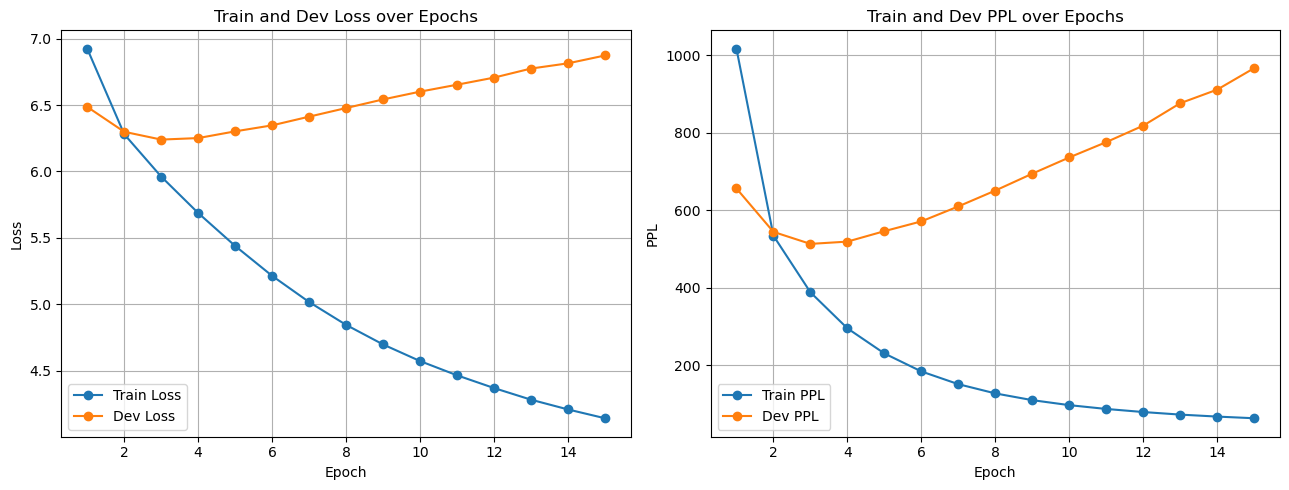

In [14]:
epochs = np.arange(1, 16)

train_nll = [6.9239, 6.2801, 5.9607, 5.6866, 5.4384, 5.2130, 5.0158, 4.8438, 4.6963, 4.5711, 4.4638, 4.3679, 4.2802, 4.2067, 4.1403]

dev_nll = [6.4859, 6.2985, 6.2399, 6.2513, 6.3020, 6.3472, 6.4127, 6.4776, 6.5425, 6.6011, 6.6534, 6.7068, 6.7751, 6.8144, 6.8735]

train_ppl = [1016.29, 533.87, 387.89, 294.89, 230.09, 183.65, 150.77, 126.95, 109.55, 96.65, 86.82, 78.87, 72.25, 67.13, 62.82]

dev_ppl = [655.85, 543.76, 512.81, 518.69, 545.65, 570.92, 609.51, 650.43, 694.01, 735.92, 775.41, 817.93, 875.80, 910.87, 966.32]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

# Loss
ax1.plot(epochs, train_nll, label='Train Loss', marker='o')
ax1.plot(epochs, dev_nll, label='Dev Loss', marker='o')
ax1.set_title('Train and Dev Loss over Epochs')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Perplexity
ax2.plot(epochs, train_ppl, label='Train PPL', marker='o')
ax2.plot(epochs, dev_ppl, label='Dev PPL', marker='o')
ax2.set_title('Train and Dev PPL over Epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('PPL')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('nll_ppl_plot_15epochs.png', format='PNG', dpi=200, bbox_inches='tight')
plt.show()


## Sentence generation with LSTM

In [ ]:
def generate_sentence(model, max_len=30, temperature=1.0):
    model.eval()

    input_token = torch.tensor([[bos_id]], dtype=torch.long).to(device)
    generated = [bos_id]
    hidden = None

    for _ in range(max_len):

        logits, hidden = model(input_token, hidden)
        logits = logits[:, -1, :] / temperature
        probs = F.softmax(logits, dim=-1).squeeze()

        token = torch.multinomial(probs, num_samples=1).item()

        generated.append(token)

        if token == eos_id:
            break

        input_token = torch.tensor([[token]], dtype=torch.long).to(device)

    return " ".join(idx_to_word[t] for t in generated[1:])


In [16]:
model.load_state_dict(torch.load("best_lstm2.pth", weights_only=True))

for i in range(5):
    print(f"Exemple {i+1} :", generate_sentence(model))


Exemple 1 : i don't know what a number of very bullying and the cities. i followed him dominant with the sucks sometimes <eos>
Exemple 2 : love cause glad you meant for that bills <eos>
Exemple 3 : will always your post makes me feel back. <eos>
Exemple 4 : yeah for the atheist ground i ripped with the fleshy <eos>
Exemple 5 : could have been correcting in a hole :’( <eos>
